In [1]:
import os

# 获取当前工作目录
current_dir = os.getcwd()
print("当前工作目录：", current_dir)
 
# 切换到上一层目录
parent_dir = os.path.dirname(current_dir)
os.chdir(parent_dir)
print("切换后的目录：", parent_dir)

当前工作目录： c:\Users\zhaoxs3\Documents\GitHub\NEMESIS\unit_test
切换后的目录： c:\Users\zhaoxs3\Documents\GitHub\NEMESIS


In [2]:
import QuantLib as ql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from devlib.market.curves.overnight_index_curves import Sofr, Estr
from devlib.market.curves.credit_curve_generator import MarketDataCreditCurve, CdsConfig
from devlib.products.credit.cds import Cds

from devlib.utils.ql_date_utils import ql_date_str
from devlib.utils.cds_utils import cds_maturity_date, calendar_5u

### Test Case 1

In [3]:
today = ql.Date(1,11,2024)
ql.Settings.instance().evaluationDate = today

mkt_file_path = './unit_test/data/ICVS530_curve_data_20241101.xlsx'
swap_mkt_data = pd.read_excel(mkt_file_path, sheet_name='swap')
discount_curve = Estr(today, swap_mkt_data=swap_mkt_data)

entity = 'EUROPE'
mkt_file_path = './unit_test/data/credit_curve_data_20241101.xlsx'
cds_type = 'index'
cds_data = pd.read_excel(mkt_file_path, sheet_name=cds_type)

cds_config = CdsConfig(recovery_rate = 0.4,
                        daycount = ql.Actual360(),
                        calendar = ql.WeekendsOnly())
daycount = ql.Actual360()

credit_curve_1 = MarketDataCreditCurve(today, entity, cds_data, discount_curve, cds_type, cds_config, daycount)

In [66]:
r = 0.025
h = 0.015
R = 0.4

prot = 1e7 * (h * (1 - R) * (1 - np.exp(-(r+h) * 10))) / (r + h)

In [67]:
t = np.arange(0.25, 10.25, step=0.25)
prem = 1e7 * (100 / 10000) * 0.254 * (np.exp(-(r+h) * t)).sum()

In [68]:
prot - prem

np.float64(-91427.22944837925)

In [81]:
cr_dv01 = 0.254 * np.exp(-(r + 98 / 10000 * (1 - R) ** -1) * t).sum() + (100 - 98) / 10000 * 0.254 / (1 - R) * (t * np.exp(-(r + 98 / 10000 * (1 - R) ** -1) * t)).sum()

In [82]:
cr_dv01 * 1e7 * 1e-4

np.float64(8292.253103635305)

In [86]:
ir_dv01 = (100 - 98) / 10000 * 0.254 * (t * np.exp(-(r + 98 / 10000 * (1 - R) ** -1) * t)).sum()

In [87]:
ir_dv01 * 1e7 * 1e-4

np.float64(7.917672228388205)

In [4]:
hazard_rate_1 = []
survival_prob_1 = []
date_list = pd.date_range("20241101", "21941220").date
for dt in date_list:
    hazard_rate_1.append(credit_curve_1.curve.hazard_rate(ql.Date(dt.day, dt.month, dt.year)))
    survival_prob_1.append(credit_curve_1.curve.survival_probability(ql.Date(dt.day, dt.month, dt.year)))

In [11]:
discount_rate_1 = []
date_list = pd.date_range("20241101", "21941220").date
for dt in date_list:
    discount_rate_1.append(discount_curve.curve.discount(ql.Date(dt.day, dt.month, dt.year)))

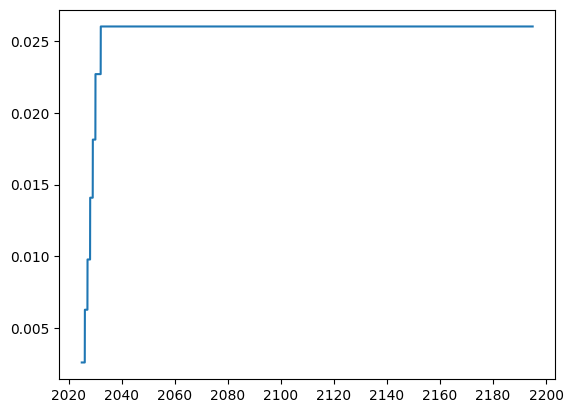

In [22]:
plt.plot(date_list, hazard_rate_1)

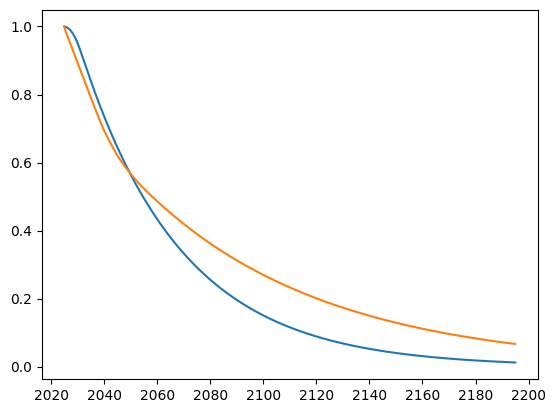

In [13]:
plt.plot(date_list, survival_prob_1)
plt.plot(date_list, discount_rate_1)

In [5]:
default_prob_1 = 1 - np.array(survival_prob_1)

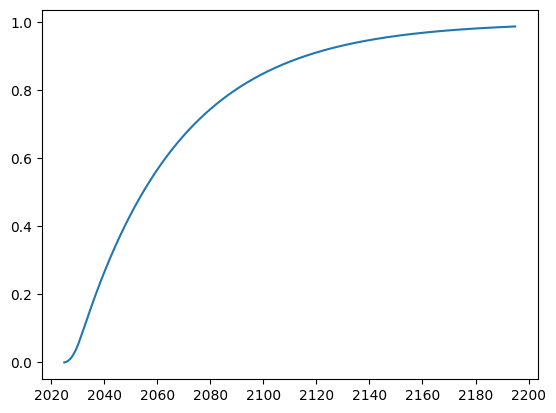

In [6]:
plt.plot(date_list, default_prob_1)

In [26]:
tenors = [f"{n}Y" for n in range(1, 50)]
npvs_1 = []
premium_1 = []
protection_1 = []
spread_dv01_1 = []
ir_dv01_1 = []

for tenor in tenors:
    spread = 100
    calendar = ql.WeekendsOnly()
    effective_date = ql.Date(1,11,2024)
    maturity_date = cds_maturity_date(effective_date, tenor)
    coupon_schedule = ql.Schedule(ql.Date(20,9,2024), maturity_date, ql.Period('3M'),
                            calendar, ql.Following, ql.Unadjusted,
                            ql.DateGeneration.CDS, False).dates()
    coupon_start_dates = np.array(coupon_schedule[:-1])
    coupon_end_dates = np.array(coupon_schedule[1:])
    coupon_end_dates[:-1] -= 1
    coupon_payment_dates = np.array(coupon_schedule[1:])
    coupon_payment_dates[-1] = calendar.adjust(coupon_payment_dates[-1])
    
    protection_start_dates = None #等价于np.array([effective_date])
    protection_end_dates = None #等价于np.array([maturity_date])
    
    direction = 'long'
    notional = 1e7
    upfront_amount = 0
    upfront_payment_date = ql.Date(6,11,2024)
    coupon_pay_front = False
    daycount = ql.Actual360()
    accrual_coupon_type = 'ToDefaultDate'
    accrual_coupon_payment_date_type = 'DefaultDate'
    recovery_rate = 0.4
    protection_payment_date_type = 'DefaultDate'

    inst = Cds(direction, notional, effective_date, maturity_date,
           upfront_amount, upfront_payment_date, coupon_pay_front, spread, daycount,
           coupon_start_dates, coupon_end_dates, coupon_payment_dates,
           accrual_coupon_type, accrual_coupon_payment_date_type,
           protection_start_dates, protection_end_dates, protection_payment_date_type, recovery_rate)
    npv = inst.npv(today, discount_curve, credit_curve_1)
    dv01_spread = inst.dv01_spread(today, discount_curve, credit_curve_1, tweak=1)
    dv01_ir = inst.dv01_ir(today, discount_curve, credit_curve_1, tweak=1e-4)
    npvs_1.append(npv)
    spread_dv01_1.append(dv01_spread)
    ir_dv01_1.append(dv01_ir)
    premium_1.append(inst.npv_coupon_survive + inst.npv_coupon_default)
    protection_1.append(inst.npv_prot)

npvs_1 = np.array(npvs_1)
premium_1 = np.array(premium_1)
protection_1 = np.array(protection_1)
spread_dv01_1 = np.array(spread_dv01_1)
ir_dv01_1 = np.array(ir_dv01_1)

In [55]:
from tqdm import tqdm

In [56]:
tenors = [f"{n}Y" for n in range(1, 50)]
npvs_s_0 = []
spread_dv01_s_0 = []
ir_dv01_s_0 = []
premium_s_0 = []
protection_s_0 = []

for tenor in tqdm(tenors):
    spread = 0
    calendar = ql.WeekendsOnly()
    effective_date = ql.Date(1,11,2024)
    maturity_date = cds_maturity_date(effective_date, tenor)
    coupon_schedule = ql.Schedule(ql.Date(20,9,2024), maturity_date, ql.Period('3M'),
                            calendar, ql.Following, ql.Unadjusted,
                            ql.DateGeneration.CDS, False).dates()
    coupon_start_dates = np.array(coupon_schedule[:-1])
    coupon_end_dates = np.array(coupon_schedule[1:])
    coupon_end_dates[:-1] -= 1
    coupon_payment_dates = np.array(coupon_schedule[1:])
    coupon_payment_dates[-1] = calendar.adjust(coupon_payment_dates[-1])
    
    protection_start_dates = None #等价于np.array([effective_date])
    protection_end_dates = None #等价于np.array([maturity_date])
    
    direction = 'long'
    notional = 1e7
    upfront_amount = 0
    upfront_payment_date = ql.Date(6,11,2024)
    coupon_pay_front = False
    daycount = ql.Actual360()
    accrual_coupon_type = 'ToDefaultDate'
    accrual_coupon_payment_date_type = 'DefaultDate'
    recovery_rate = 0.4
    protection_payment_date_type = 'DefaultDate'

    inst = Cds(direction, notional, effective_date, maturity_date,
           upfront_amount, upfront_payment_date, coupon_pay_front, spread, daycount,
           coupon_start_dates, coupon_end_dates, coupon_payment_dates,
           accrual_coupon_type, accrual_coupon_payment_date_type,
           protection_start_dates, protection_end_dates, protection_payment_date_type, recovery_rate)
    npv = inst.npv(today, discount_curve, credit_curve_1)
    dv01_spread = inst.dv01_spread(today, discount_curve, credit_curve_1, tweak=1)
    dv01_ir = inst.dv01_ir(today, discount_curve, credit_curve_1, tweak=1e-4)
    npvs_s_0.append(npv)
    spread_dv01_s_0.append(dv01_spread)
    ir_dv01_s_0.append(dv01_ir)
    premium_s_0.append(inst.npv_coupon_survive + inst.npv_coupon_default)
    protection_s_0.append(inst.npv_prot)

npvs_s_0 = np.array(npvs_s_0)
premium_s_0 = np.array(premium_s_0)
protection_s_0 = np.array(protection_s_0)
spread_dv01_s_0 = np.array(spread_dv01_s_0)
ir_dv01_s_0 = np.array(ir_dv01_s_0)

100%|██████████| 49/49 [14:48<00:00, 18.13s/it]


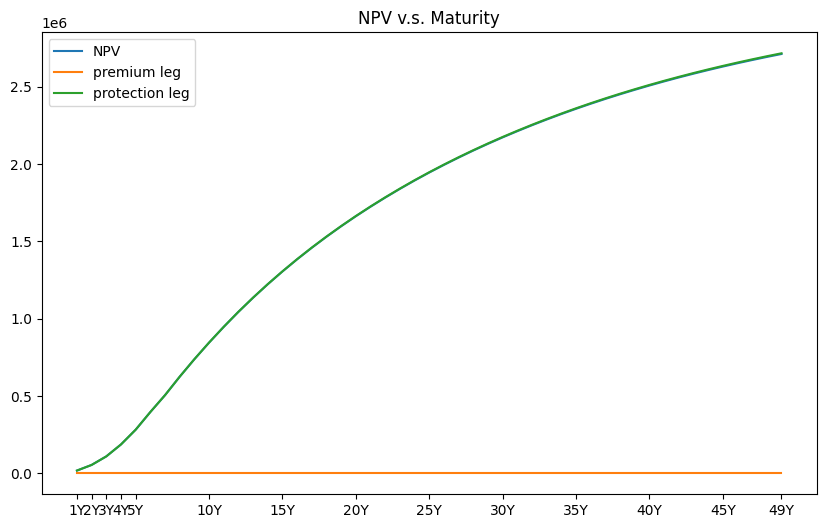

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(tenors, npvs_s_0, label="NPV")
plt.plot(tenors, premium_s_0, label="premium leg")
plt.plot(tenors, protection_s_0, label="protection leg")
plt.title("NPV v.s. Maturity")
target_ticks = [0,1,2,3,4,9,14,19,24,29,34,39,44,48]
plt.xticks(target_ticks, [f"{i+1}Y" for i in target_ticks])
plt.legend()

In [58]:
tenors = [f"{n}Y" for n in range(1, 50)]
npvs_s_500 = []
spread_dv01_s_500 = []
ir_dv01_s_500 = []
premium_s_500 = []
protection_s_500 = []

for tenor in tqdm(tenors):
    spread = 500
    calendar = ql.WeekendsOnly()
    effective_date = ql.Date(1,11,2024)
    maturity_date = cds_maturity_date(effective_date, tenor)
    coupon_schedule = ql.Schedule(ql.Date(20,9,2024), maturity_date, ql.Period('3M'),
                            calendar, ql.Following, ql.Unadjusted,
                            ql.DateGeneration.CDS, False).dates()
    coupon_start_dates = np.array(coupon_schedule[:-1])
    coupon_end_dates = np.array(coupon_schedule[1:])
    coupon_end_dates[:-1] -= 1
    coupon_payment_dates = np.array(coupon_schedule[1:])
    coupon_payment_dates[-1] = calendar.adjust(coupon_payment_dates[-1])
    
    protection_start_dates = None #等价于np.array([effective_date])
    protection_end_dates = None #等价于np.array([maturity_date])
    
    direction = 'long'
    notional = 1e7
    upfront_amount = 0
    upfront_payment_date = ql.Date(6,11,2024)
    coupon_pay_front = False
    daycount = ql.Actual360()
    accrual_coupon_type = 'ToDefaultDate'
    accrual_coupon_payment_date_type = 'DefaultDate'
    recovery_rate = 0.4
    protection_payment_date_type = 'DefaultDate'

    inst = Cds(direction, notional, effective_date, maturity_date,
           upfront_amount, upfront_payment_date, coupon_pay_front, spread, daycount,
           coupon_start_dates, coupon_end_dates, coupon_payment_dates,
           accrual_coupon_type, accrual_coupon_payment_date_type,
           protection_start_dates, protection_end_dates, protection_payment_date_type, recovery_rate)
    npv = inst.npv(today, discount_curve, credit_curve_1)
    dv01_spread = inst.dv01_spread(today, discount_curve, credit_curve_1, tweak=1)
    dv01_ir = inst.dv01_ir(today, discount_curve, credit_curve_1, tweak=1e-4)
    npvs_s_500.append(npv)
    spread_dv01_s_500.append(dv01_spread)
    ir_dv01_s_500.append(dv01_ir)
    premium_s_500.append(inst.npv_coupon_survive + inst.npv_coupon_default)
    protection_s_500.append(inst.npv_prot)

npvs_s_500 = np.array(npvs_s_500)
premium_s_500 = np.array(premium_s_500)
protection_s_500 = np.array(protection_s_500)
spread_dv01_s_500 = np.array(spread_dv01_s_500)
ir_dv01_s_500 = np.array(ir_dv01_s_500)

100%|██████████| 49/49 [16:23<00:00, 20.06s/it]


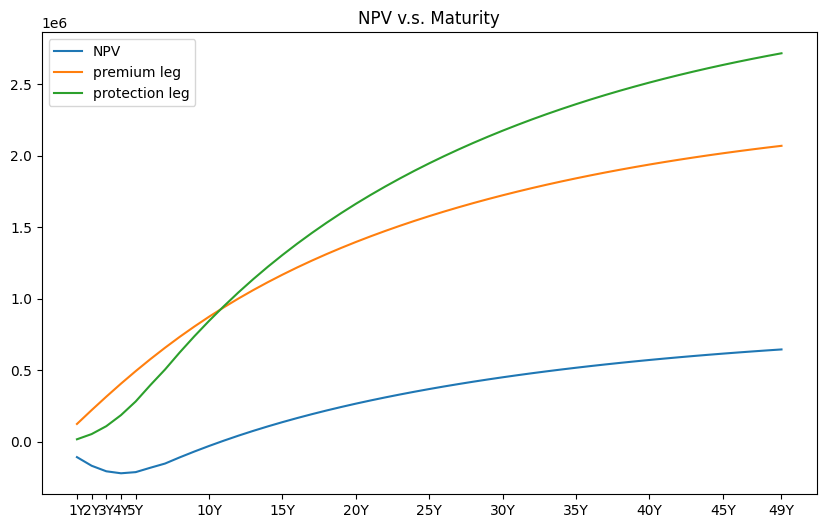

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(tenors, npvs_1, label="NPV")
plt.plot(tenors, premium_1, label="premium leg")
plt.plot(tenors, protection_1, label="protection leg")
plt.title("NPV v.s. Maturity")
target_ticks = [0,1,2,3,4,9,14,19,24,29,34,39,44,48]
plt.xticks(target_ticks, [f"{i+1}Y" for i in target_ticks])
plt.legend()

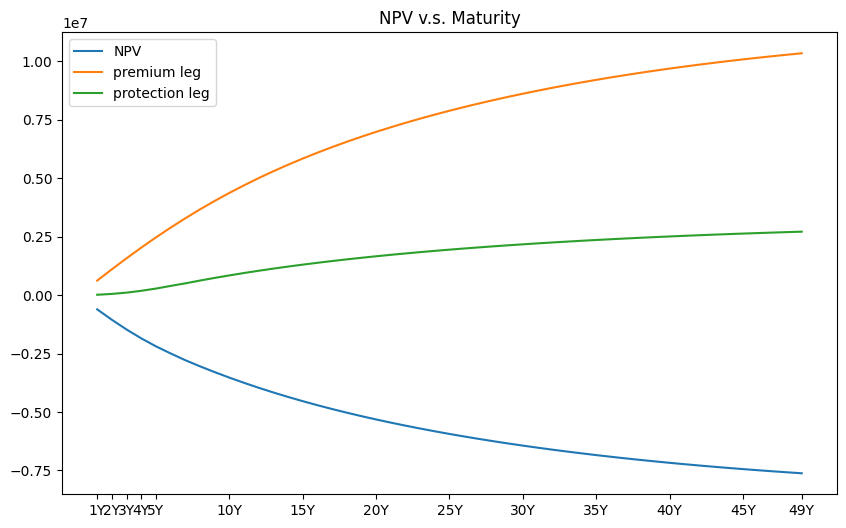

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(tenors, npvs_s_500, label="NPV")
plt.plot(tenors, premium_s_500, label="premium leg")
plt.plot(tenors, protection_s_500, label="protection leg")
plt.title("NPV v.s. Maturity")
target_ticks = [0,1,2,3,4,9,14,19,24,29,34,39,44,48]
plt.xticks(target_ticks, [f"{i+1}Y" for i in target_ticks])
plt.legend()

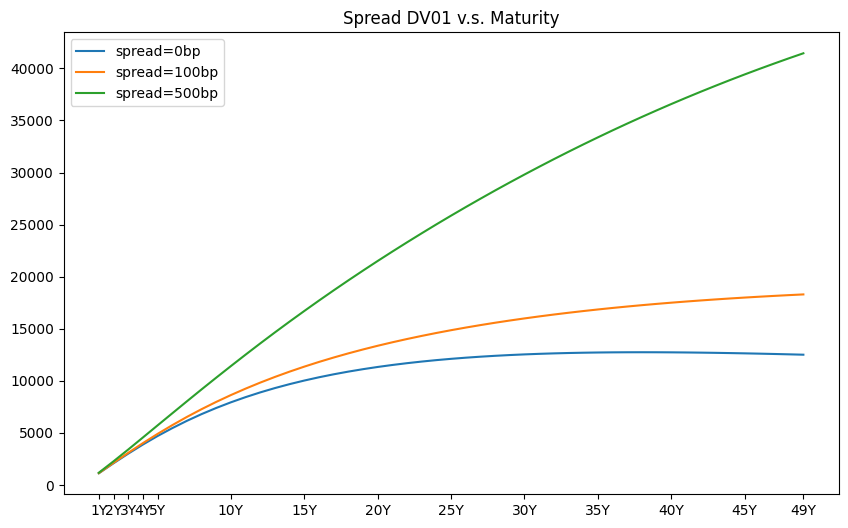

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(tenors, spread_dv01_s_0, label="spread=0bp")
plt.plot(tenors, spread_dv01_1, label="spread=100bp")
plt.plot(tenors, spread_dv01_s_500, label="spread=500bp")
plt.title("Spread DV01 v.s. Maturity")
target_ticks = [0,1,2,3,4,9,14,19,24,29,34,39,44,48]
plt.xticks(target_ticks, [f"{i+1}Y" for i in target_ticks])
plt.legend()

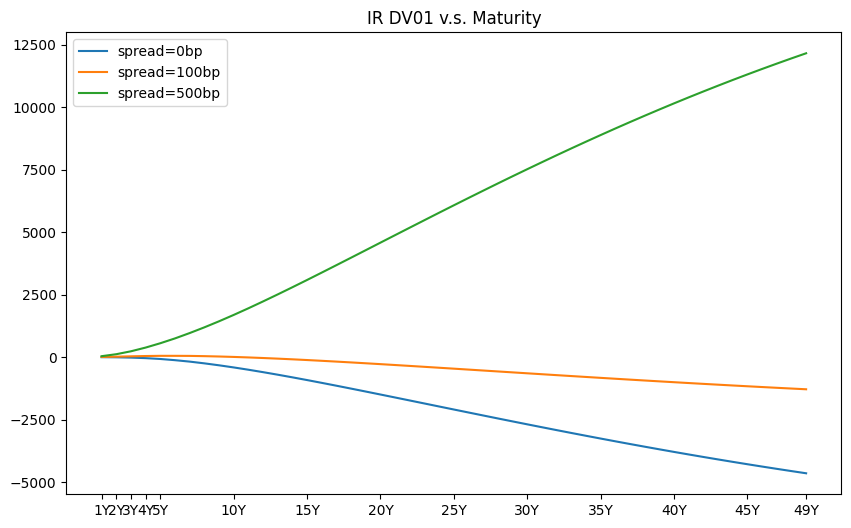

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(tenors, ir_dv01_s_0, label="spread=0bp")
plt.plot(tenors, ir_dv01_1, label="spread=100bp")
plt.plot(tenors, ir_dv01_s_500, label="spread=500bp")
plt.title("IR DV01 v.s. Maturity")
target_ticks = [0,1,2,3,4,9,14,19,24,29,34,39,44,48]
plt.xticks(target_ticks, [f"{i+1}Y" for i in target_ticks])
plt.legend()

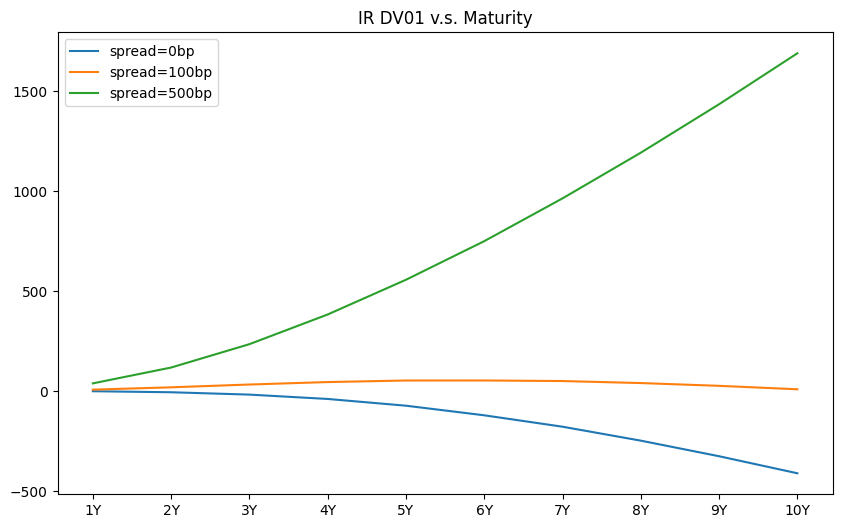

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(tenors[:10], ir_dv01_s_0[:10], label="spread=0bp")
plt.plot(tenors[:10], ir_dv01_1[:10], label="spread=100bp")
plt.plot(tenors[:10], ir_dv01_s_500[:10], label="spread=500bp")
plt.title("IR DV01 v.s. Maturity")
# target_ticks = [0,1,2,3,4,9,14,19,24,29,34,39,44,48]
# plt.xticks(target_ticks, [f"{i+1}Y" for i in target_ticks])
plt.legend()

In [15]:
spreads = [10, 50, 100, 200, 300, 400, 500]
npvs_1 = []
premium_1 = []
protection_1 = []
spread_dv01_1 = []
ir_dv01_1 = []

for spread in spreads:
    calendar = ql.WeekendsOnly()
    effective_date = ql.Date(1,11,2024)
    maturity_date = cds_maturity_date(effective_date, "10Y")
    coupon_schedule = ql.Schedule(ql.Date(20,9,2024), maturity_date, ql.Period('3M'),
                            calendar, ql.Following, ql.Unadjusted,
                            ql.DateGeneration.CDS, False).dates()
    coupon_start_dates = np.array(coupon_schedule[:-1])
    coupon_end_dates = np.array(coupon_schedule[1:])
    coupon_end_dates[:-1] -= 1
    coupon_payment_dates = np.array(coupon_schedule[1:])
    coupon_payment_dates[-1] = calendar.adjust(coupon_payment_dates[-1])
    
    protection_start_dates = None #等价于np.array([effective_date])
    protection_end_dates = None #等价于np.array([maturity_date])
    
    direction = 'long'
    notional = 1e7
    upfront_amount = 0
    upfront_payment_date = ql.Date(6,11,2024)
    coupon_pay_front = False
    daycount = ql.Actual360()
    accrual_coupon_type = 'ToDefaultDate'
    accrual_coupon_payment_date_type = 'DefaultDate'
    recovery_rate = 0.4
    protection_payment_date_type = 'DefaultDate'

    inst = Cds(direction, notional, effective_date, maturity_date,
           upfront_amount, upfront_payment_date, coupon_pay_front, spread, daycount,
           coupon_start_dates, coupon_end_dates, coupon_payment_dates,
           accrual_coupon_type, accrual_coupon_payment_date_type,
           protection_start_dates, protection_end_dates, protection_payment_date_type, recovery_rate)
    npv = inst.npv(today, discount_curve, credit_curve_1)
    dv01_spread = inst.dv01_spread(today, discount_curve, credit_curve_1, tweak=1)
    dv01_ir = inst.dv01_ir(today, discount_curve, credit_curve_1, tweak=1e-4)
    npvs_1.append(npv)
    spread_dv01_1.append(dv01_spread)
    ir_dv01_1.append(dv01_ir)
    premium_1.append(inst.npv_coupon_survive + inst.npv_coupon_default)
    protection_1.append(inst.npv_prot)

npvs_1 = np.array(npvs_1)
premium_1 = np.array(premium_1)
protection_1 = np.array(protection_1)
spread_dv01_1 = np.array(spread_dv01_1)
ir_dv01_1 = np.array(ir_dv01_1)

In [43]:
inst = Cds(direction, notional, effective_date, maturity_date,
        upfront_amount, upfront_payment_date, coupon_pay_front, 97.99, daycount,
        coupon_start_dates, coupon_end_dates, coupon_payment_dates,
        accrual_coupon_type, accrual_coupon_payment_date_type,
        protection_start_dates, protection_end_dates, protection_payment_date_type, recovery_rate)
inst.npv(today, discount_curve, credit_curve_1)

np.float64(-11581.35806739)

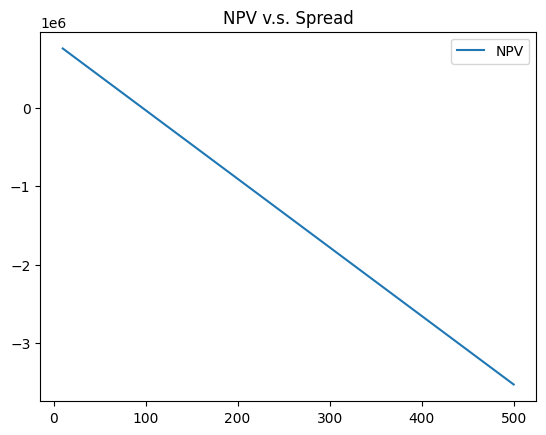

In [19]:
plt.plot(spreads, npvs_1, label="NPV")
plt.title("NPV v.s. Spread")
plt.legend()

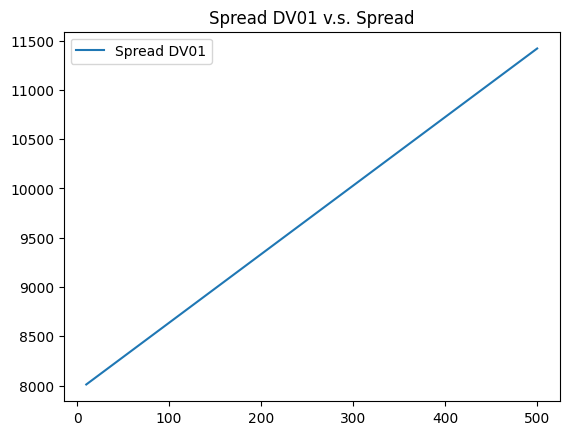

In [20]:
plt.plot(spreads, spread_dv01_1, label="Spread DV01")
plt.title("Spread DV01 v.s. Spread")
plt.legend()

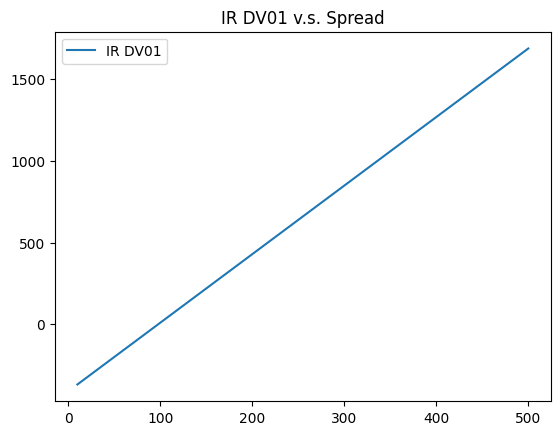

In [21]:
plt.plot(spreads, ir_dv01_1, label="IR DV01")
plt.title("IR DV01 v.s. Spread")
plt.legend()

### Test Case 2

In [3]:
today = ql.Date(1,11,2024)
ql.Settings.instance().evaluationDate = today

mkt_file_path = './unit_test/data/ICVS531_curve_data_20241101.xlsx'
swap_mkt_data = pd.read_excel(mkt_file_path, sheet_name='swap')
discount_curve = Sofr(today, swap_mkt_data=swap_mkt_data)

entity = 'CHINAGOV'
mkt_file_path = './unit_test/data/credit_curve_data_20241101.xlsx'
cds_type = 'single_name'
cds_data = pd.read_excel(mkt_file_path, sheet_name=cds_type)

cds_config = CdsConfig(recovery_rate = 0.4,
                        daycount = ql.Actual360(),
                        calendar = calendar_5u())
daycount = ql.Actual360()

credit_curve_2 = MarketDataCreditCurve(today, entity, cds_data, discount_curve, cds_type, cds_config, daycount)

In [74]:
hazard_rate_2 = []
survival_prob_2 = []
date_list = pd.date_range("20241101", "20341220").date
for dt in date_list:
    hazard_rate_2.append(credit_curve_2.curve.hazard_rate(ql.Date(dt.day, dt.month, dt.year)))
    survival_prob_2.append(credit_curve_2.curve.survival_probability(ql.Date(dt.day, dt.month, dt.year)))

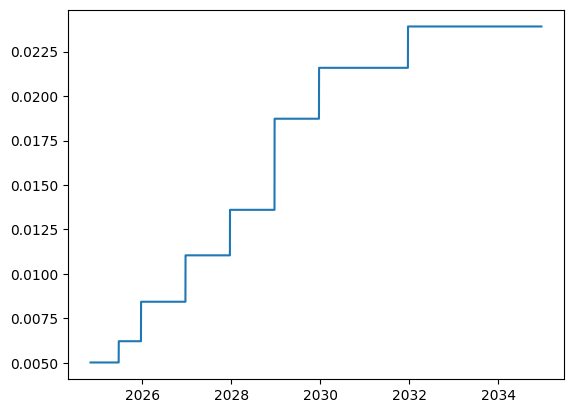

In [75]:
plt.plot(date_list, hazard_rate_2)

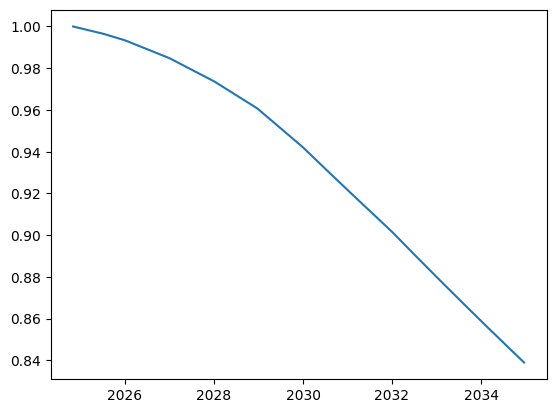

In [76]:
plt.plot(date_list, survival_prob_2)

In [13]:
tenors = [f"{n}Y" for n in range(1, 11)]
npvs_2 = []
# premium_2 = []
# protection_2 = []
spread_dv01_2 = []
ir_dv01_2 = []

for tenor in tenors:
    spread = 500

    calendar = calendar_5u()

    effective_date = ql.Date(1,11,2024)
    maturity_date = cds_maturity_date(effective_date, tenor)
    coupon_schedule = ql.Schedule(ql.Date(20,9,2024), maturity_date, ql.Period('3M'),
                                calendar, ql.Following, ql.Unadjusted,
                                ql.DateGeneration.CDS, False).dates()
    coupon_start_dates = np.array(coupon_schedule[:-1])
    # coupon_start_dates[0] = step_in_date
    coupon_end_dates = np.array(coupon_schedule[1:])
    coupon_end_dates[:-1] -= 1
    coupon_payment_dates = np.array(coupon_schedule[1:])
    coupon_payment_dates[-1] = calendar.adjust(coupon_payment_dates[-1])

    protection_start_dates = None
    protection_end_dates = None

    direction = 'long'
    notional = 1e7
    upfront_amount = 0
    upfront_payment_date = ql.Date(6,11,2024)
    coupon_pay_front = False
    daycount = ql.Actual360()
    accrual_coupon_type = 'ToDefaultDate'
    accrual_coupon_payment_date_type = 'DefaultDate'
    recovery_rate = 0.4
    protection_payment_date_type = 'DefaultDate'

    inst = Cds(direction, notional, effective_date, maturity_date,
            upfront_amount, upfront_payment_date,
            coupon_pay_front, spread, daycount,
            coupon_start_dates, coupon_end_dates, coupon_payment_dates,
            accrual_coupon_type, accrual_coupon_payment_date_type,
            protection_start_dates, protection_end_dates, protection_payment_date_type, recovery_rate)
    
    npv = inst.npv(today, discount_curve, credit_curve_2)
    dv01_spread = inst.dv01_spread(today, discount_curve, credit_curve_2, tweak=1)
    dv01_ir = inst.dv01_ir(today, discount_curve, credit_curve_2, tweak=1e-4)
    npvs_2.append(npv)
    # premium_2.append(inst.npv_coupon_survive + inst.npv_coupon_default)
    # protection_2.append(inst.npv_prot)
    spread_dv01_2.append(dv01_spread)
    ir_dv01_2.append(dv01_ir)

npvs_2 = np.array(npvs_2)
# premium_2 = np.array(premium_2)
# protection_2 = np.array(protection_2)
spread_dv01_2 = np.array(spread_dv01_2)
ir_dv01_2 = np.array(ir_dv01_2)

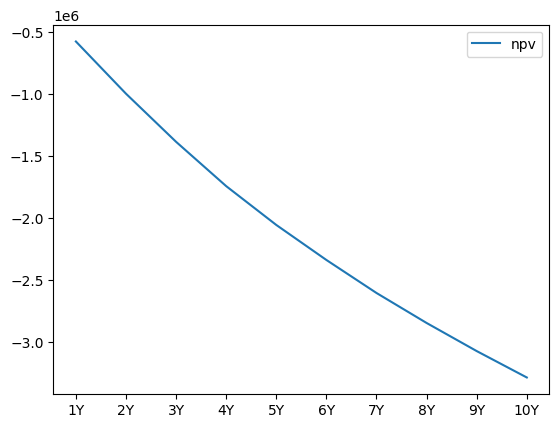

In [14]:
plt.plot(tenors, npvs_2, label="npv")
# plt.plot(tenors, premium_2, label="premium leg")
# plt.plot(tenors, protection_2, label="protection leg")
plt.legend()

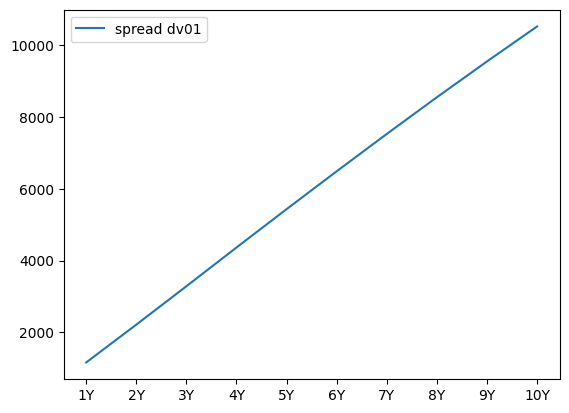

In [15]:
plt.plot(tenors, spread_dv01_2, label="spread dv01")
plt.legend()

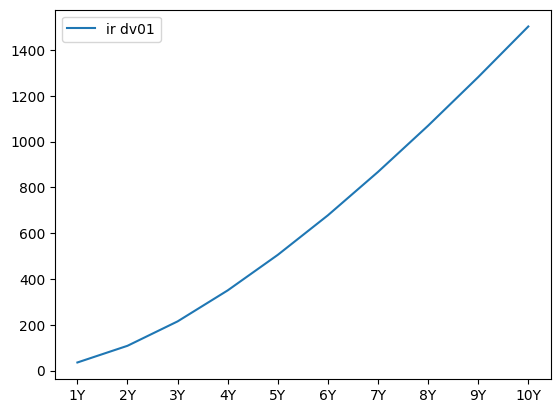

In [16]:
plt.plot(tenors, ir_dv01_2, label="ir dv01")
plt.legend()

In [5]:
spreads = [10, 50, 100, 200, 300, 400, 500]
npvs_2 = []
# premium_2 = []
# protection_2 = []
spread_dv01_2 = []
ir_dv01_2 = []

for spread in spreads:

    calendar = calendar_5u()

    effective_date = ql.Date(1,11,2024)
    maturity_date = cds_maturity_date(effective_date, "10Y")
    coupon_schedule = ql.Schedule(ql.Date(20,9,2024), maturity_date, ql.Period('3M'),
                                calendar, ql.Following, ql.Unadjusted,
                                ql.DateGeneration.CDS, False).dates()
    coupon_start_dates = np.array(coupon_schedule[:-1])
    # coupon_start_dates[0] = step_in_date
    coupon_end_dates = np.array(coupon_schedule[1:])
    coupon_end_dates[:-1] -= 1
    coupon_payment_dates = np.array(coupon_schedule[1:])
    coupon_payment_dates[-1] = calendar.adjust(coupon_payment_dates[-1])

    protection_start_dates = None
    protection_end_dates = None

    direction = 'long'
    notional = 1e7
    upfront_amount = 0
    upfront_payment_date = ql.Date(6,11,2024)
    coupon_pay_front = False
    daycount = ql.Actual360()
    accrual_coupon_type = 'ToDefaultDate'
    accrual_coupon_payment_date_type = 'DefaultDate'
    recovery_rate = 0.4
    protection_payment_date_type = 'DefaultDate'

    inst = Cds(direction, notional, effective_date, maturity_date,
            upfront_amount, upfront_payment_date,
            coupon_pay_front, spread, daycount,
            coupon_start_dates, coupon_end_dates, coupon_payment_dates,
            accrual_coupon_type, accrual_coupon_payment_date_type,
            protection_start_dates, protection_end_dates, protection_payment_date_type, recovery_rate)
    
    npv = inst.npv(today, discount_curve, credit_curve_2)
    dv01_spread = inst.dv01_spread(today, discount_curve, credit_curve_2, tweak=1)
    dv01_ir = inst.dv01_ir(today, discount_curve, credit_curve_2, tweak=1e-4)
    npvs_2.append(npv)
    # premium_2.append(inst.npv_coupon_survive + inst.npv_coupon_default)
    # protection_2.append(inst.npv_prot)
    spread_dv01_2.append(dv01_spread)
    ir_dv01_2.append(dv01_ir)

npvs_2 = np.array(npvs_2)
# premium_2 = np.array(premium_2)
# protection_2 = np.array(protection_2)
spread_dv01_2 = np.array(spread_dv01_2)
ir_dv01_2 = np.array(ir_dv01_2)

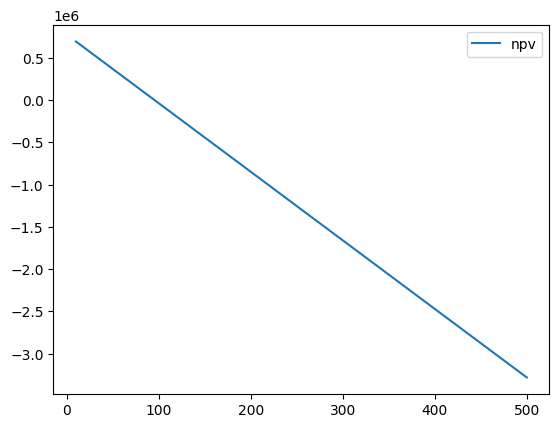

In [7]:
plt.plot(spreads, npvs_2, label="npv")
plt.legend()

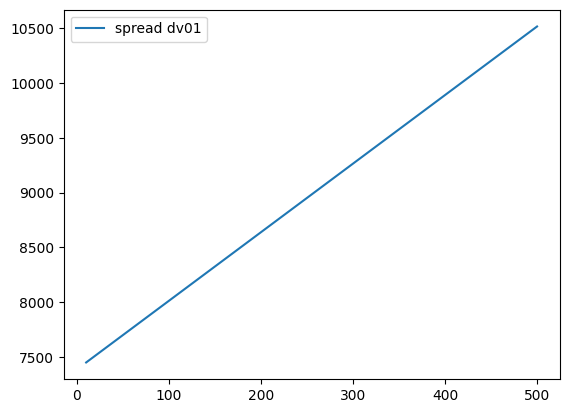

In [8]:
plt.plot(spreads, spread_dv01_2, label="spread dv01")
plt.legend()

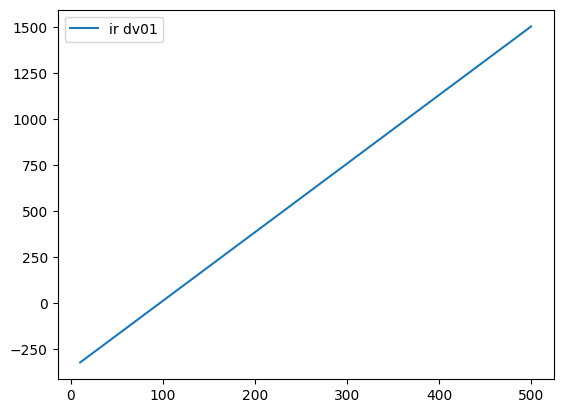

In [9]:
plt.plot(spreads, ir_dv01_2, label="ir dv01")
plt.legend()

In [91]:
df = pd.DataFrame({"Date": date_list, "Test 1": hazard_rate_1, "Test 2": hazard_rate_2}).set_index("Date")

In [93]:
df = pd.DataFrame({"Date": date_list, "Test 1": survival_prob_1, "Test 2": survival_prob_2}).set_index("Date")

<Axes: xlabel='Date'>

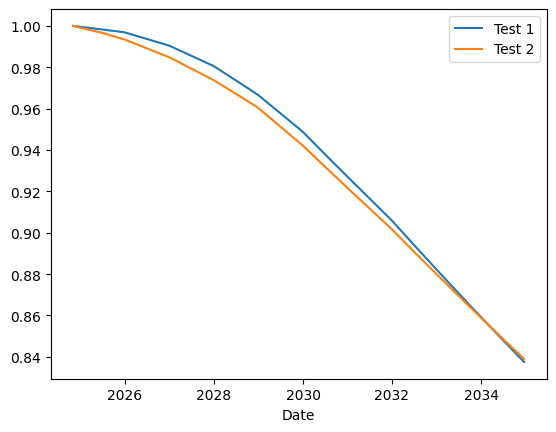

In [94]:
df.plot()